## Extrating Data from API
To reproduce this code, a new token should be retrived from:
+ https://analisi.transparenciacatalunya.cat/Educaci-/Avaluaci-de-sis-d-educaci-prim-ria/rk5x-gny6/about_data
+ https://analisi.transparenciacatalunya.cat/Educaci-/Avaluaci-de-quart-d-Educaci-Secund-ria-Obligat-ria/59vm-wwq7/about_data

In [79]:
import pandas as pd
from sodapy import Socrata
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "5fdymyZntjECVai1ZmolqKBeG")

# Fetch results as JSON and convert them to a Python list of dictionaries
results = client.get("rk5x-gny6",limit=1000000) #"rk5x-gny6" for database

# Convert to pandas DataFrame
comp = pd.DataFrame.from_records(results)

Fourth grade secondary school:

In [32]:
# Replace None with your app token "AVDM_Competencies" for authenticated access
client = Socrata("analisi.transparenciacatalunya.cat", "5fdymyZntjECVai1ZmolqKBeG")

# Fetch results as JSON and convert them to a Python list of dictionaries
results4 = client.get("59vm-wwq7",limit=1000000) #"59vm-wwq7" for database

# Convert to pandas DataFrame
comp4 = pd.DataFrame.from_records(results4)

## Data Handeling

Error handeling. We drop null values and only keep the columns we want.

In [35]:
#Take columns we want of 6th grade and drop null values
comp6_med = comp[['codi_alumne','pcat', 'pcast', 'pmat', 'pang','pmed']]
comp6_med = comp6_med.dropna()

In [37]:
#Take columns we want of 10th grade and drop null values
comp4_med = comp4[['codi_alumne','pcat','pcast','pmat','pang','pcien']]
comp4_med = comp4_med.dropna()

Data Modification. Make the mean of rows thant have the same numerical code.

In [40]:
#For 6th grade:
comp6_med = comp6_med.apply(pd.to_numeric, errors='coerce')

# Made the mean of marks for repeated student codes 
df_mean6_med = comp6_med.groupby('codi_alumne').agg({
    'pcat': 'mean',  
    'pcast': 'mean',
    'pang': 'mean',
    'pmed': 'mean',
    'pmat': 'mean'
}).reset_index()

In [44]:
#For 10th grade:
comp4_med = comp4_med.apply(pd.to_numeric, errors='coerce')

#Made the mean of marks for repeated student codes
df_mean4_med = comp4_med.groupby('codi_alumne').agg({
    'pcat': 'mean',  
    'pcast': 'mean',
    'pang': 'mean',
    'pmat': 'mean',
    'pcien': 'mean'
}).reset_index()

## Correlation matrix
I plotted correlation matrixes to check the correlation between marks in different subjects.

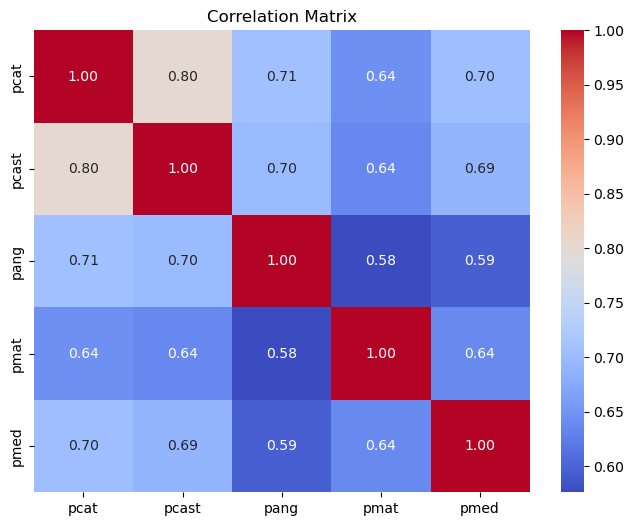

In [51]:
# For 6th grade:
df = df_mean6_med
correlation_matrix = df[['pcat', 'pcast', 'pang', 'pmat', 'pmed']].corr() #Selection of subjects

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f") #Prepare heatmap
plt.title("Correlation Matrix")
plt.savefig('corrmatrix.png')
plt.show()

## Results:
+ Cat and cast very related 0.8
+ Cat and cast related to english 0.7
+ English mostly related to languages and slightly related to maths and sciences
+ Maths not related to english, mostly related to cast and cat, and med because of compression of the problems
+ med mostly related to cat and cast and a little to math.
+ Maths and med not related much to english

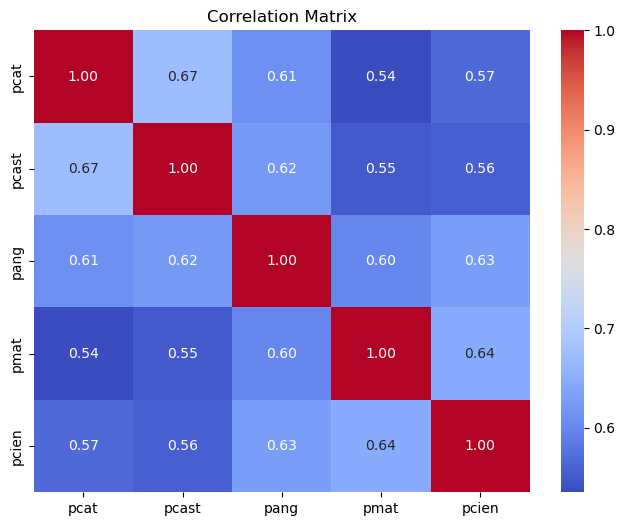

In [53]:
# For 10th grade:
df = df_mean4_med
correlation_matrix = df[['pcat', 'pcast', 'pang', 'pmat', 'pcien']].corr() #Select subjects

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f") #Select heatmap
plt.title("Correlation Matrix")
plt.show()

## Results
+ Cat and cast, still related but less than before
+ Sciences more related to maths and english than before
+ math more related to sciences and english than to cat and cast
+ cat and cast more related to english than to maths and science
+ It seems than science and math have moved away from english

New column. Mean mark for 6th grade and 10th grade:

In [57]:
df_mean6_med['mark'] = df_mean6_med[['pcat', 'pcast', 'pang', 'pmat','pmed']].mean(axis=1)
df_mean4_med['mark'] = df_mean4_med[['pcat', 'pcast', 'pang', 'pmat','pcien']].mean(axis=1)

## Boxplot for 6th grade


In [59]:
#Select quartiles
top_10 = df_mean6_med["mark"].quantile(0.9)  # 90%
worst_10 = df_mean6_med["mark"].quantile(0.1)  # 10%
q45 = df_mean6_med["mark"].quantile(0.45)       # 45%
q55 = df_mean6_med["mark"].quantile(0.55)       # 55%

#Select three samples of good, normal and bad students:
top6 = df_mean6_med[df_mean6_med["mark"] >= top_10]
worst6 = df_mean6_med[df_mean6_med["mark"] <= worst_10]
mid6 = df_mean6_med[(df_mean6_med["mark"] >= q45) & (df_mean6_med["mark"] <= q55)]

In [61]:
#Print standard deviation:
print(top['pcat'].std(),top['pcast'].std(),top['pang'].std(),top['pmat'].std(),top['pmed'].std())
print(mid['pcat'].std(),mid['pcast'].std(),mid['pang'].std(),mid['pmat'].std(),mid['pmed'].std())
print(worst['pcat'].std(),worst['pcast'].std(),worst['pang'].std(),worst['pmat'].std(),worst['pmed'].std())

NameError: name 'top' is not defined

In [63]:
#Create new column for the general classification:
top6['group'] = 'Top 10'
mid6['group'] = 'Middies'
worst6['group'] = 'Bottom 10'

/var/folders/7b/q70snpc170jf3dn2zy9d01b00000gn/T/ipykernel_12169/490251831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top6['group'] = 'Top 10'
/var/folders/7b/q70snpc170jf3dn2zy9d01b00000gn/T/ipykernel_12169/490251831.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid6['group'] = 'Middies'
/var/folders/7b/q70snpc170jf3dn2zy9d01b00000gn/T/ipykernel_12169/490251831.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [65]:
#Create new dataframe with three samples of good normal and bad students:
df_combined6 = pd.concat([top6, mid6, worst6], ignore_index=True)
df_combined6 = df_combined6.rename(index = str, columns = {"pcat": "Catalan","pcast": "Spanish","pang": "English","pmat": "Maths","pmed": "Science"})

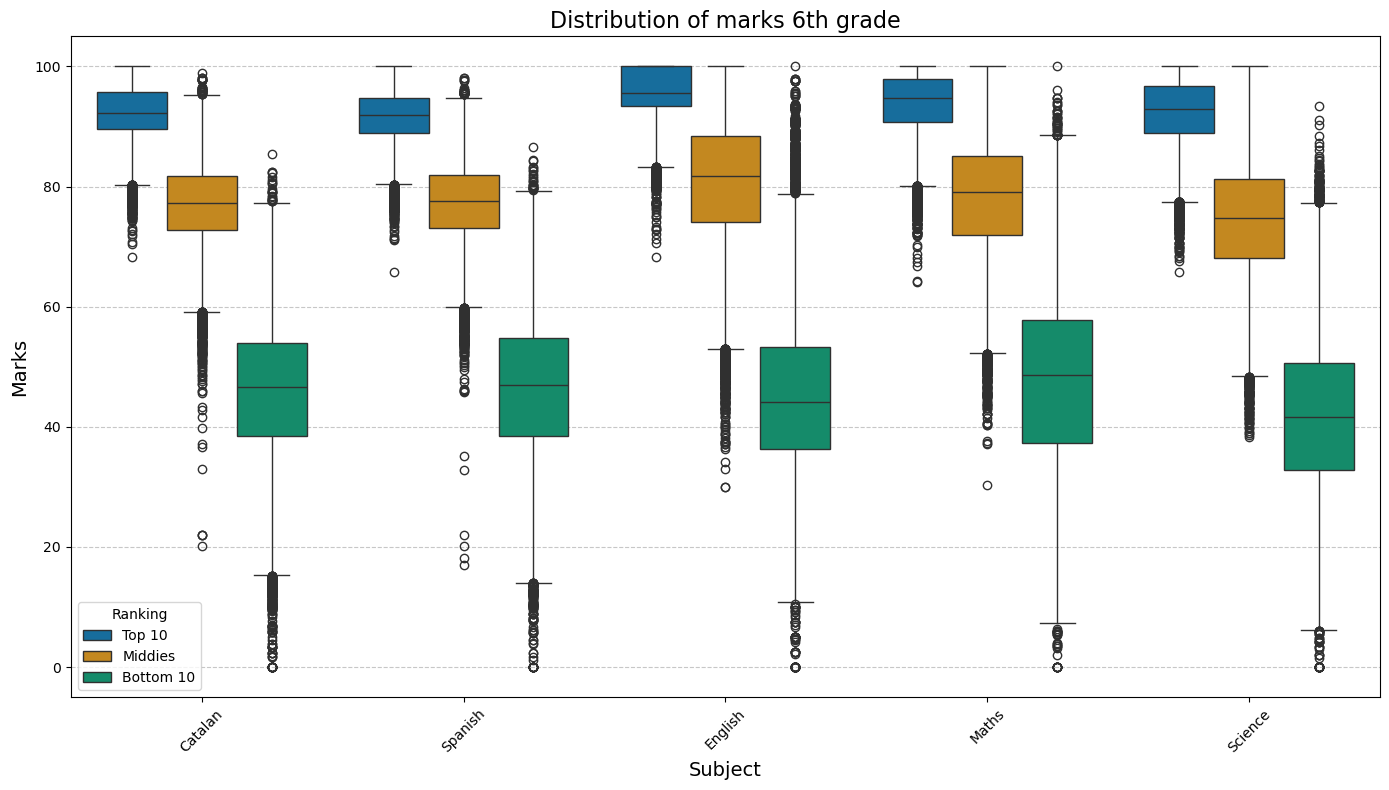

In [67]:
#Draw the boxplot for 6th grade:

df_long = pd.melt(df_combined6, id_vars=['group'], value_vars=['Catalan', 'Spanish', 'English', 'Maths', 'Science'],
                  var_name='subject', value_name='subject_mark') 
colors = sns.color_palette("colorblind")[:3] #color palette

# Create figure
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_long, x='subject', y='subject_mark', hue='group', palette=colors) #Hue are the different groups represented for each subject

plt.title('Distribution of marks 6th grade', fontsize=16)
plt.xlabel('Subject', fontsize=14)
plt.ylabel('Marks', fontsize=14)
plt.legend(title='Ranking', loc='best', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('sisèboxplot.png')
plt.show()


## Boxplot for 10th grade:

In [69]:
#Select quartiles:
top_10 = df_mean4_med["mark"].quantile(0.9)  # 90%
worst_10 = df_mean4_med["mark"].quantile(0.1)  # 10%
q45 = df_mean4_med["mark"].quantile(0.45)       # 45%
q55 = df_mean4_med["mark"].quantile(0.55)       # 55%

# Make three samples with good, normal and bad students:
top4 = df_mean4_med[df_mean4_med["mark"] >= top_10]
worst4 = df_mean4_med[df_mean4_med["mark"] <= worst_10]
mid4 = df_mean4_med[(df_mean4_med["mark"] >= q45) & (df_mean4_med["mark"] <= q55)]

In [71]:
#Create new column depending on general mark:
top4['group'] = 'Top 10'
mid4['group'] = 'Middies'
worst4['group'] = 'Bottom 10'

/var/folders/7b/q70snpc170jf3dn2zy9d01b00000gn/T/ipykernel_12169/3024575615.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top4['group'] = 'Top 10'
/var/folders/7b/q70snpc170jf3dn2zy9d01b00000gn/T/ipykernel_12169/3024575615.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mid4['group'] = 'Middies'
/var/folders/7b/q70snpc170jf3dn2zy9d01b00000gn/T/ipykernel_12169/3024575615.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [73]:
#Create new database with three selected samples:
df_combined4 = pd.concat([top4, mid4, worst4], ignore_index=True)
df_combined4 = df_combined4.rename(index = str, columns = {"pcat": "Catalan","pcast": "Spanish","pang": "English","pmat": "Maths","pcien": "Science"})

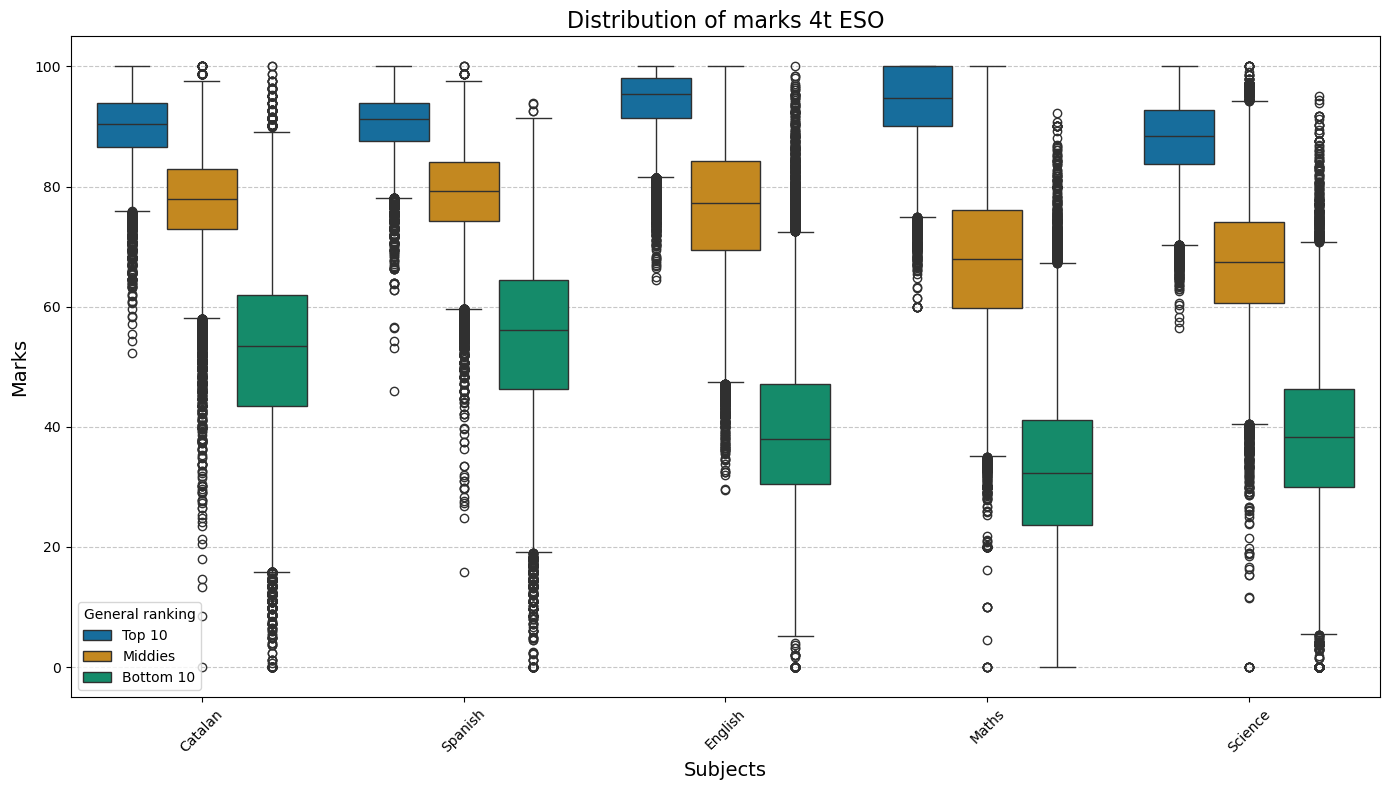

In [75]:
#Code for the boxplot:

df_long = pd.melt(df_combined4, id_vars=['group'], value_vars=['Catalan', 'Spanish', 'English', 'Maths', 'Science'],
                  var_name='subject', value_name='subject_mark')
colors = sns.color_palette("colorblind")[:3] #color palette

#Create figure
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_long, x='subject', y='subject_mark', hue='group', palette=colors) #hue are three samples for each subject

#Personalize
plt.title('Distribution of marks 4t ESO', fontsize=16)
plt.xlabel('Subjects', fontsize=14)
plt.ylabel('Marks', fontsize=14)
plt.legend(title='General ranking', loc='best', fontsize=10)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('quartboxplot.png')
plt.show()

In [131]:
#Check standard deviation:
print(top['pcat'].std(),top['pcast'].std(),top['pang'].std(),top['pmat'].std(),top['pcien'].std())
print(mid['pcat'].std(),mid['pcast'].std(),mid['pang'].std(),mid['pmat'].std(),mid['pcien'].std())
print(worst['pcat'].std(),worst['pcast'].std(),worst['pang'].std(),worst['pmat'].std(),worst['pcien'].std())

5.316813557794489 4.897304697342462 4.902062388413328 6.054701043213598 6.509354133708942
8.067387097357356 7.469164082629952 10.770295130459223 12.535246049168581 10.229740953934765
13.919067524032213 13.512043311141564 12.84953284008716 14.661523593212817 12.171525765311873


## Radar plot for 10th grade, best students:

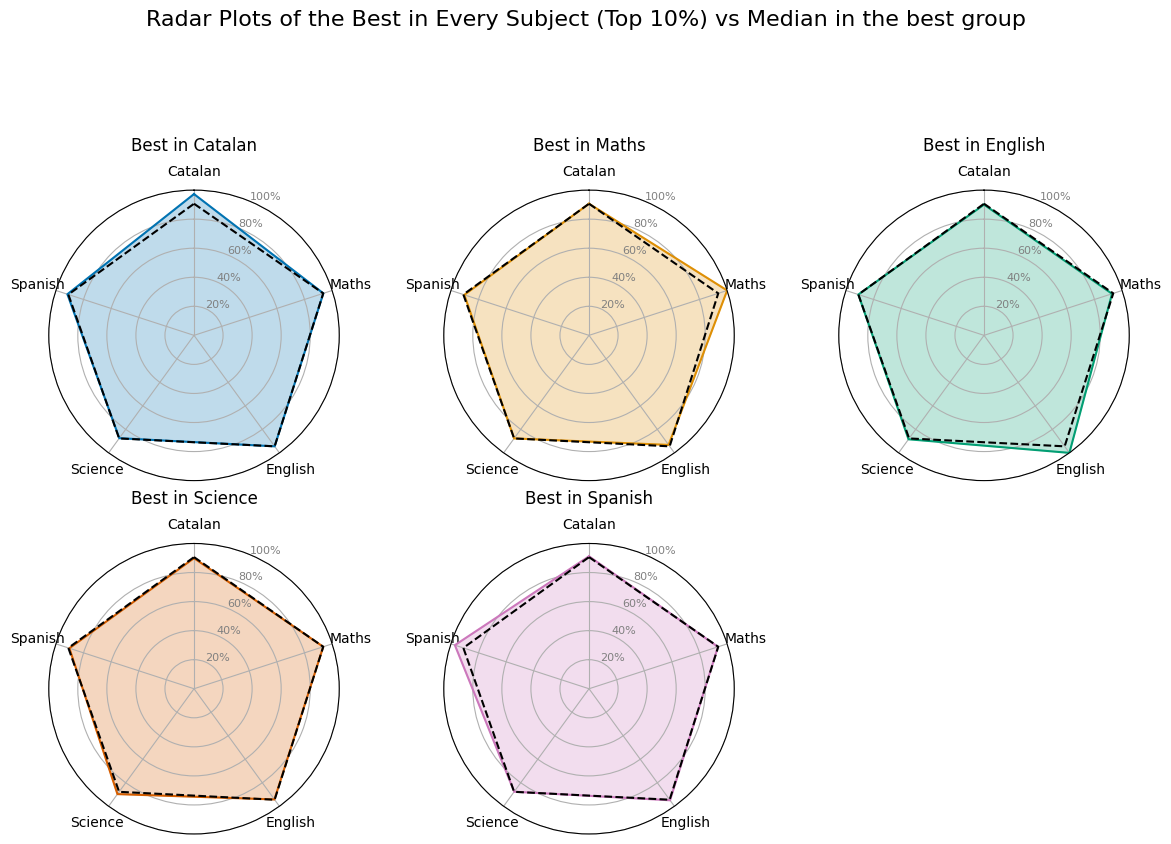

In [273]:
# Definde percentage for talented students at that subject
top_percentage = 0.10  

# Find quartiles
top_pcat = top4['pcat'].quantile(1 - top_percentage)
top_pmat = top4['pmat'].quantile(1 - top_percentage)
top_pang = top4['pang'].quantile(1 - top_percentage)
top_pmed = top4['pcien'].quantile(1 - top_percentage)
top_pcast = top4['pcast'].quantile(1 - top_percentage)

# Select best students
best_pcat_group = top4[top4['pcat'] >= top_pcat]
best_pmat_group = top4[top4['pmat'] >= top_pmat]
best_pang_group = top4[top4['pang'] >= top_pang]
best_pmed_group = top4[top4['pcien'] >= top_pcien]
best_pcast_group = top4[top4['pcast'] >= top_pcast]

summary_data = pd.DataFrame({
    'Subjects': ['Catalan', 'Maths', 'English', 'Science','Spanish'],
    'Best in Catalan': [best_pcat_group['pcat'].mean(), best_pcat_group['pmat'].mean(), best_pcat_group['pang'].mean(), best_pcat_group['pcien'].mean(),best_pcat_group['pcast'].mean() ],
    'Best in Maths': [best_pmat_group['pcat'].mean(), best_pmat_group['pmat'].mean(), best_pmat_group['pang'].mean(), best_pmat_group['pcien'].mean(),best_pmat_group['pcast'].mean()],
    'Best in English': [best_pang_group['pcat'].mean(), best_pang_group['pmat'].mean(), best_pang_group['pang'].mean(), best_pang_group['pcien'].mean(),best_pang_group['pcast'].mean()],
    'Best in Science': [best_pmed_group['pcat'].mean(), best_pmed_group['pmat'].mean(), best_pmed_group['pang'].mean(), best_pmed_group['pcien'].mean(),best_pmed_group['pcast'].mean()],
    'Best in Spanish': [best_pcast_group['pcat'].mean(), best_pcast_group['pmat'].mean(), best_pcast_group['pang'].mean(), best_pcast_group['pcien'].mean(),best_pcast_group['pcast'].mean()],

}).set_index('Subjects')

# Normalize data
radar_data = summary_data / summary_data.max().max()

# Find angles
labels = radar_data.index
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

# Find color palette
colors = sns.color_palette("colorblind")[:5]

# Create grid
fig, axs = plt.subplots(2, 3, figsize=(12, 8), subplot_kw=dict(polar=True))

# Iterate for radar plots
for ax, column, color, title in zip(axs.flat[:5], radar_data.columns, colors, radar_data.columns):
    values = radar_data[column].values.flatten().tolist()
    values += values[:1]  

    # Draw colored line of best students
    ax.plot(angles, values, label=title, color=color)
    ax.fill(angles, values, color=color, alpha=0.25)
    
    # Draw black dotted line with median for each subject
    medians = radar_data.median(axis=1).values.tolist()
    medians += medians[:1]  
    ax.plot(angles, medians, linestyle='--', color='black', label="Mediana")
    
    # Configure subplot
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=12, pad=10)

# Hide 6th subplot
if axs.size > 5:
    for ax in axs.flat[5:]:
        ax.axis("off")

# Personalize 
plt.suptitle("Radar Plots of the Best in Every Subject (Top 10%) vs Median in the best group", size=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('beststar.png')
plt.show()

## Radar plot for 10th grade, average students:

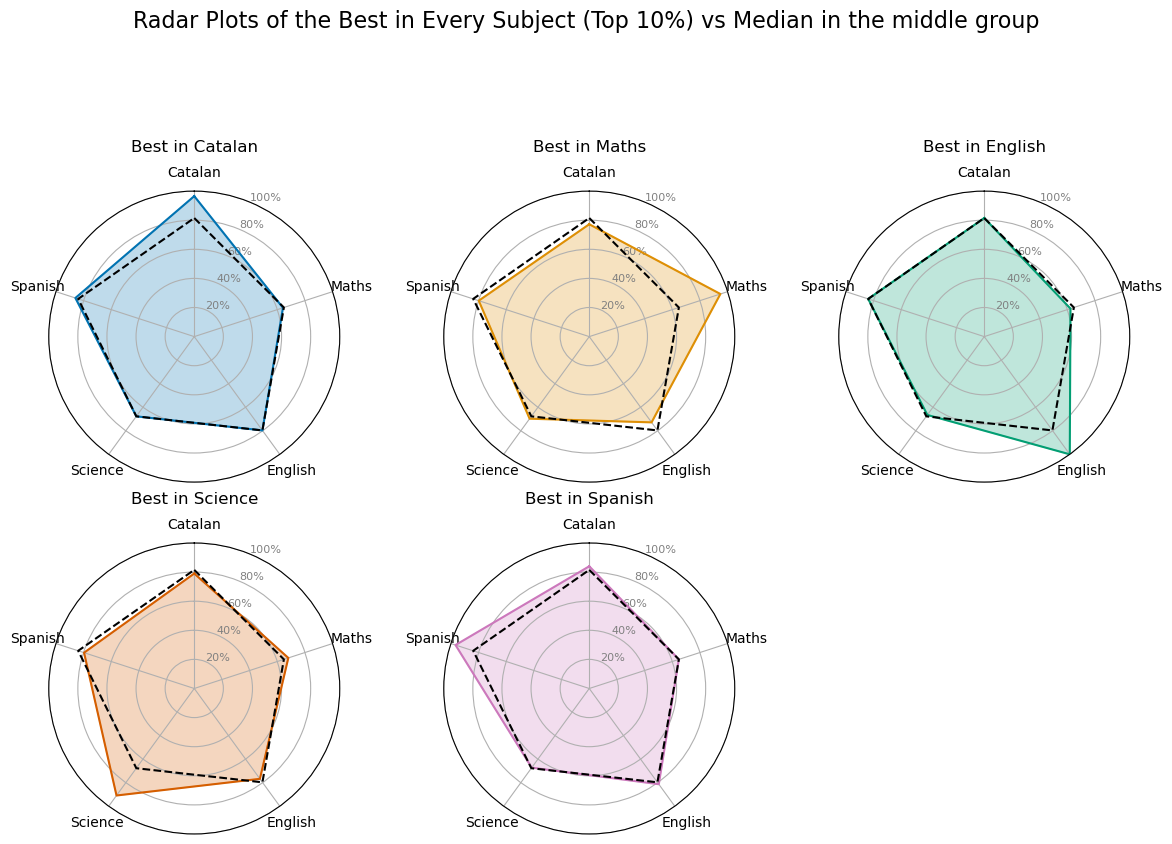

In [81]:
# Define percentage for talented students in each sample
top_percentage = 0.10  

# Find quartiles in top sample for each subject
top_pcat = mid4['pcat'].quantile(1 - top_percentage)
top_pmat = mid4['pmat'].quantile(1 - top_percentage)
top_pang = mid4['pang'].quantile(1 - top_percentage)
top_pcien = mid4['pcien'].quantile(1 - top_percentage)
top_pcast = mid4['pcast'].quantile(1 - top_percentage)


# Select best students according to percentage
best_pcat_group = mid4[mid4['pcat'] >= top_pcat]
best_pmat_group = mid4[mid4['pmat'] >= top_pmat]
best_pang_group = mid4[mid4['pang'] >= top_pang]
best_pcien_group = mid4[mid4['pcien'] >= top_pcien]
best_pcast_group = mid4[mid4['pcast'] >= top_pcast]

summary_data = pd.DataFrame({
    'Subjects': ['Catalan', 'Maths', 'English', 'Science', 'Spanish'],
    'Best in Catalan': [
        best_pcat_group['pcat'].mean(), 
        best_pcat_group['pmat'].mean(), 
        best_pcat_group['pang'].mean(), 
        best_pcat_group['pcien'].mean(),
        best_pcat_group['pcast'].mean()
    ],
    'Best in Maths': [
        best_pmat_group['pcat'].mean(), 
        best_pmat_group['pmat'].mean(), 
        best_pmat_group['pang'].mean(), 
        best_pmat_group['pcien'].mean(),
        best_pmat_group['pcast'].mean()
    ],
    'Best in English': [
        best_pang_group['pcat'].mean(), 
        best_pang_group['pmat'].mean(), 
        best_pang_group['pang'].mean(), 
        best_pang_group['pcien'].mean(),
        best_pang_group['pcast'].mean()
    ],
    'Best in Science': [
        best_pcien_group['pcat'].mean(), 
        best_pcien_group['pmat'].mean(), 
        best_pcien_group['pang'].mean(), 
        best_pcien_group['pcien'].mean(),
        best_pcien_group['pcast'].mean()
    ],
    'Best in Spanish': [
        best_pcast_group['pcat'].mean(), 
        best_pcast_group['pmat'].mean(), 
        best_pcast_group['pang'].mean(), 
        best_pcast_group['pcien'].mean(),
        best_pcast_group['pcast'].mean()
    ]
}).set_index('Subjects')


# Normalize data
radar_data = summary_data / summary_data.max().max()
# Find angles for radar plot
labels = radar_data.index
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

# Colours for each subject
colors = sns.color_palette("colorblind")[:5]

# Create grid
fig, axs = plt.subplots(2, 3, figsize=(12, 8), subplot_kw=dict(polar=True))

# Iterate and add median dotted line
for ax, column, color, title in zip(axs.flat[:5], radar_data.columns, colors, radar_data.columns):
    values = radar_data[column].values.flatten().tolist()
    values += values[:1]  
    
    # Draw talented students
    ax.plot(angles, values, label=title, color=color)
    ax.fill(angles, values, color=color, alpha=0.25)
    
    # Draw median
    medians = radar_data.median(axis=1).values.tolist()
    medians += medians[:1]  # Tornar al punt d'origen
    ax.plot(angles, medians, linestyle='--', color='black', label="Mediana")
    
    # Configure subplot
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=12, pad=10)

# Hide 6th subplot
if axs.size > 5:
    for ax in axs.flat[5:]:
        ax.axis("off")

# Personalize
plt.suptitle("Radar Plots of the Best in Every Subject (Top 10%) vs Median in the middle group", size=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.savefig('midstar.png')
plt.show()

## Radar plot for 10th grade, worst students:

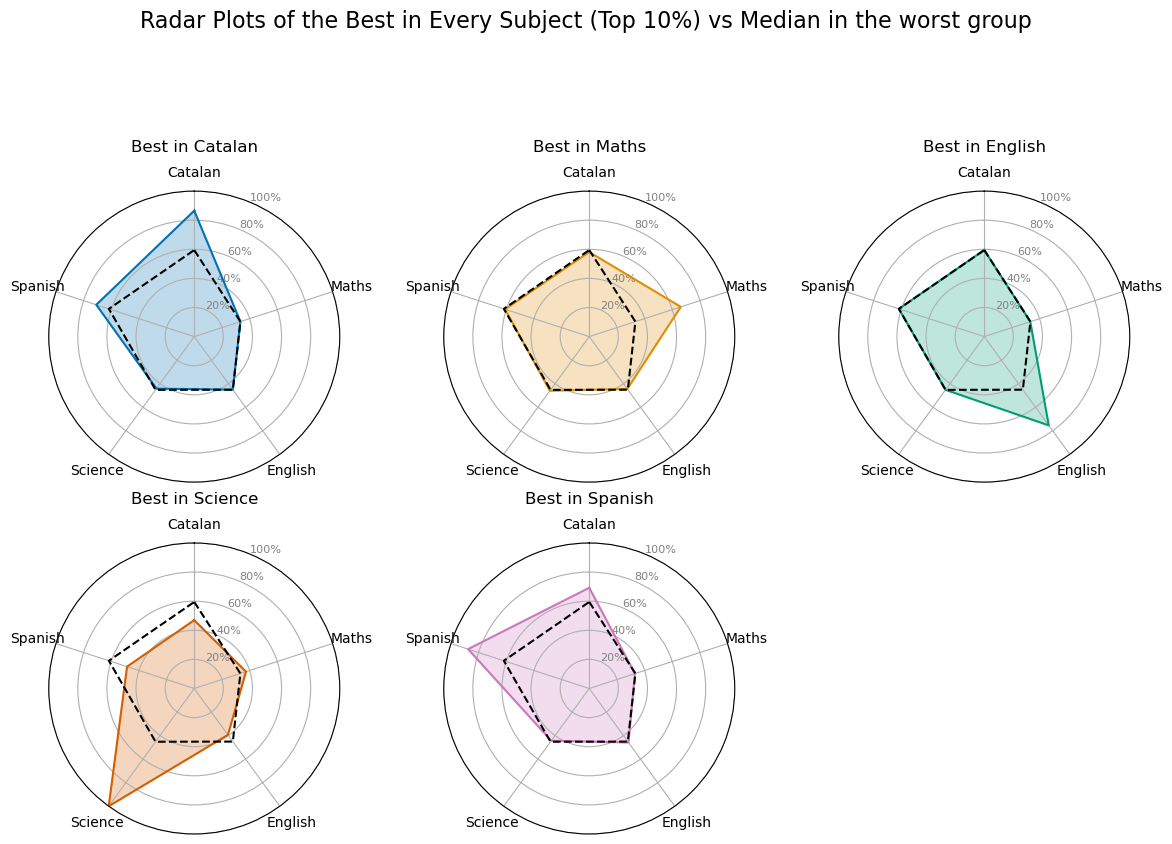

In [83]:
#Find to select top students for that subject within sample
top_percentage = 0.10  

# Find quartiles for each subject
top_pcat = worst4['pcat'].quantile(1 - top_percentage)
top_pmat = worst4['pmat'].quantile(1 - top_percentage)
top_pang = worst4['pang'].quantile(1 - top_percentage)
top_pmed = worst4['pcien'].quantile(1 - top_percentage)
top_pcast = worst4['pcast'].quantile(1 - top_percentage)

# Select best students according to percentage
best_pcat_group = worst4[worst4['pcat'] >= top_pcat]
best_pmat_group = worst4[worst4['pmat'] >= top_pmat]
best_pang_group = worst4[worst4['pang'] >= top_pang]
best_pmed_group = worst4[worst4['pcien'] >= top_pcien]
best_pcast_group = worst4[worst4['pcast'] >= top_pcast]

summary_data = pd.DataFrame({
    'Subjects': ['Catalan', 'Maths', 'English', 'Science','Spanish'],
    'Best in Catalan': [best_pcat_group['pcat'].mean(), best_pcat_group['pmat'].mean(), best_pcat_group['pang'].mean(), best_pcat_group['pcien'].mean(),best_pcat_group['pcast'].mean() ],
    'Best in Maths': [best_pmat_group['pcat'].mean(), best_pmat_group['pmat'].mean(), best_pmat_group['pang'].mean(), best_pmat_group['pcien'].mean(),best_pmat_group['pcast'].mean()],
    'Best in English': [best_pang_group['pcat'].mean(), best_pang_group['pmat'].mean(), best_pang_group['pang'].mean(), best_pang_group['pcien'].mean(),best_pang_group['pcast'].mean()],
    'Best in Science': [best_pmed_group['pcat'].mean(), best_pmed_group['pmat'].mean(), best_pmed_group['pang'].mean(), best_pmed_group['pcien'].mean(),best_pmed_group['pcast'].mean()],
    'Best in Spanish': [best_pcast_group['pcat'].mean(), best_pcast_group['pmat'].mean(), best_pcast_group['pang'].mean(), best_pcast_group['pcien'].mean(),best_pcast_group['pcast'].mean()],

}).set_index('Subjects')

# Normalize data
radar_data = summary_data / summary_data.max().max()

# Find angles
labels = radar_data.index
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  

# color palette
colors = sns.color_palette("colorblind")[:5]

# Create grid
fig, axs = plt.subplots(2, 3, figsize=(12, 8), subplot_kw=dict(polar=True))

# Iterate for radar plots and add median
for ax, column, color, title in zip(axs.flat[:5], radar_data.columns, colors, radar_data.columns):
    values = radar_data[column].values.flatten().tolist()
    values += values[:1]  # Tornar al punt d'origen

    # Draw colored line of best students
    ax.plot(angles, values, label=title, color=color)
    ax.fill(angles, values, color=color, alpha=0.25)
    
    # Find and draw median
    medians = radar_data.median(axis=1).values.tolist()
    medians += medians[:1]  # Tornar al punt d'origen
    ax.plot(angles, medians, linestyle='--', color='black', label="Mediana")
    
    # Configure subplot
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["20%", "40%", "60%", "80%", "100%"], color="grey", size=8)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=12, pad=10)

# Hide 6th subplot
if axs.size > 5:
    for ax in axs.flat[5:]:
        ax.axis("off")

# personalize
plt.suptitle("Radar Plots of the Best in Every Subject (Top 10%) vs Median in the worst group", size=16, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('worststar.png')
plt.show()